<h1 style="text-align:center;">Predicción de conversión de clientes para un banco portugués</h1>

<div style="text-align: right">Joaquín Bardauil</div>
<div style="text-align: right">Última edición: 15/09/2021</div>
<br>
<br>
<br>


El dataset tiene datos de clientes de un banco portugués y sus interacciones con las campañas de marketing. La variable target tiene categorías que indican si un cliente depositó un plazo fijo en el banco. El objetivo es poder predecir si un cliente depositará un plazo fijo a partir de las campañas de marketing. Para eso, evaluaré los datos, realizaré un análisis descriptivo y evaluaré una serie de modelos de clasificación.

This dataset is based on "Bank Marketing" UCI dataset (please check the description at: http://archive.ics.uci.edu/ml/datasets/Bank+Marketing).
   The data is enriched by the addition of five new social and economic features/attributes (national wide indicators from a ~10M population country), published by the Banco de Portugal and publicly available at: https://www.bportugal.pt/estatisticasweb.
   This dataset is almost identical to the one used in [Moro et al., 2014] (it does not include all attributes due to privacy concerns). 
   
   
   
S. Moro, P. Cortez and P. Rita. A Data-Driven Approach to Predict the Success of Bank Telemarketing. Decision Support Systems, In press, http://dx.doi.org/10.1016/j.dss.2014.03.001


<details>
    <summary>Descripción de las features</summary>
    <ol>
        <li>age (numeric)</li>
        <li>job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')</li>
        <li>marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)</li>
        <li>education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')</li>
        <li>default: has credit in default? (categorical: 'no','yes','unknown')</li>
        <li>housing: has housing loan? (categorical: 'no','yes','unknown')</li>
        <li>loan: has personal loan? (categorical: 'no','yes','unknown')</li>
        <hr>
        <li>contact: contact communication type (categorical: 'cellular','telephone')</li>
        <li>month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')</li>
        <li>day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')</li>
        <li>duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.</li>
        <hr>
        <li>campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)</li>
        <li>pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)</li>
        <li>previous: number of contacts performed before this campaign and for this client (numeric)</li>
        <li>poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')</li>
        <hr>
        <li>emp.var.rate: employment variation rate - quarterly indicator (numeric)</li>
        <li>cons.price.idx: consumer price index - monthly indicator (numeric)</li>
        <li>cons.conf.idx: consumer confidence index - monthly indicator (numeric)</li>
        <li>euribor3m: euribor 3 month rate - daily indicator (numeric)</li>
        <li>nr.employed: number of employees - quarterly indicator (numeric)</li>
    </ol>
</details>

---

El desafío planteado es un problema de clasificación binaria con clases desbalanceadas e inputs numéricos y categóricos. Teniendo esto en cuenta, en el siguiente notebook:
- Codifico las variables categóricas para agregarlas a los modelos predictivos.
- Creo features a partir de las observaciones del análisis exploratorio.
- Oversampleo la clase minoritaria para balancear el dataset usando la técnica SMOTE
- Entreno diferentes modelos de clasificación
- Para la evaluación de los modelos, tengo en cuenta la curva ROC y la curva de Precision-Recall. Dado que hay muchos datos de la clase mayoritaria, los modelos tenderán a aprender a predecirla con un accuracy muy alto. Sin embargo, los modelos tendrán muchos falsos negativos, dado que no pudieron entrenar satisfactoriamente para predecir la clase minoritaria. Para observar que eso no suceda es conveniente enfocarse en la métrica recall.

In [1]:
from pathlib import Path
import time
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, recall_score
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import precision_recall_curve, average_precision_score
from xgboost.sklearn import XGBClassifier
from catboost import CatBoostClassifier
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as imbalanced_pipeline

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [2]:
p = Path('.')
df = pd.read_csv(p / 'bank-additional-full (9).csv', sep=';')

# Análisis exploratorio

In [3]:
df.head()

age        job  marital    education  default housing loan    contact  \
0   56  housemaid  married     basic.4y       no      no   no  telephone   
1   57   services  married  high.school  unknown      no   no  telephone   
2   37   services  married  high.school       no     yes   no  telephone   
3   40     admin.  married     basic.6y       no      no   no  telephone   
4   56   services  married  high.school       no      no  yes  telephone   

  month day_of_week  ...  campaign  pdays  previous     poutcome emp.var.rate  \
0   may         mon  ...         1    999         0  nonexistent          1.1   
1   may         mon  ...         1    999         0  nonexistent          1.1   
2   may         mon  ...         1    999         0  nonexistent          1.1   
3   may         mon  ...         1    999         0  nonexistent          1.1   
4   may         mon  ...         1    999         0  nonexistent          1.1   

   cons.price.idx  cons.conf.idx  euribor3m  nr.employed   y  
0          93.994          -36.4      4.857       5191.0  no  
1          93.994          -36.4      4.857       5191.0  no  
2          93.994          -36.4      4.857       5191.0  no  
3          93.994          -36.4      4.857       5191.0  no  
4          93.994          -36.4      4.857       5191.0  no  

[5 rows x 21 columns]

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

## Datos faltantes

In [5]:
df.isnull().sum()

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64

El dataset no tiene valores NaN. Sin embargo, luego se verá que hay datos faltantes en las variantes categóricas representados con la etiqueta "unknown".

# Wrangling

In [6]:
X = df.copy()
y = X.pop('y')

### Features categóricas

In [7]:
cat_features = X.select_dtypes('object')
cat_features

job  marital            education  default housing loan  \
0        housemaid  married             basic.4y       no      no   no   
1         services  married          high.school  unknown      no   no   
2         services  married          high.school       no     yes   no   
3           admin.  married             basic.6y       no      no   no   
4         services  married          high.school       no      no  yes   
...            ...      ...                  ...      ...     ...  ...   
41183      retired  married  professional.course       no     yes   no   
41184  blue-collar  married  professional.course       no      no   no   
41185      retired  married    university.degree       no     yes   no   
41186   technician  married  professional.course       no      no   no   
41187      retired  married  professional.course       no     yes   no   

         contact month day_of_week     poutcome  
0      telephone   may         mon  nonexistent  
1      telephone   may         mon  nonexistent  
2      telephone   may         mon  nonexistent  
3      telephone   may         mon  nonexistent  
4      telephone   may         mon  nonexistent  
...          ...   ...         ...          ...  
41183   cellular   nov         fri  nonexistent  
41184   cellular   nov         fri  nonexistent  
41185   cellular   nov         fri  nonexistent  
41186   cellular   nov         fri  nonexistent  
41187   cellular   nov         fri      failure  

[41188 rows x 10 columns]

In [8]:
cat_features.nunique().sort_values(ascending=False)

job            12
month          10
education       8
day_of_week     5
marital         4
poutcome        3
loan            3
housing         3
default         3
contact         2
dtype: int64

In [9]:
cat_features[cat_features=='unknown'].count()

job             330
marital          80
education      1731
default        8597
housing         990
loan            990
contact           0
month             0
day_of_week       0
poutcome          0
dtype: int64

Estrategia de codificación para features categóricas:

- Codifico ```month``` y ```day_of_week``` especialmente.
- Factorizo el resto de las variables para evitar aumento de la dimensionalidad.
- Codifico también el target.

In [10]:
def encode_date_data(X):
    day_of_week_encoding = dict(zip(
        df.day_of_week.unique(),
        np.arange(1,6)
    ))
    X.day_of_week = X.day_of_week.apply(lambda x: day_of_week_encoding[x])

    month_encoding = dict(zip(
        df.month.unique(),
        np.arange(1,13)
    ))
    X.month = X.month.apply(lambda x: month_encoding[x])
    return X

def encode_cat_features(X):
    categorical_features = [
        'contact',
        'default',
        'housing',
        'loan',
        'marital',
        'poutcome',
        'job',
        'education'
    ]

#     for feature in categorical_features:
#         dummies = pd.get_dummies(X[feature], drop_first=True, prefix=feature)
#         X = X.drop(feature, axis=1)
#         X = X.join(dummies)

    for feature in categorical_features:
        X[feature], _ = X[feature].factorize()

    return X

def encode_target(y):
    return pd.Series(LabelEncoder().fit_transform(y))

def encode_data(X, y):
    X = encode_date_data(X)
    X = encode_cat_features(X)
    y = encode_target(y)
    return X, y

In [11]:
numerical_features = X.select_dtypes(['int64', 'float64'])
numerical_features

age  duration  campaign  pdays  previous  emp.var.rate  cons.price.idx  \
0       56       261         1    999         0           1.1          93.994   
1       57       149         1    999         0           1.1          93.994   
2       37       226         1    999         0           1.1          93.994   
3       40       151         1    999         0           1.1          93.994   
4       56       307         1    999         0           1.1          93.994   
...    ...       ...       ...    ...       ...           ...             ...   
41183   73       334         1    999         0          -1.1          94.767   
41184   46       383         1    999         0          -1.1          94.767   
41185   56       189         2    999         0          -1.1          94.767   
41186   44       442         1    999         0          -1.1          94.767   
41187   74       239         3    999         1          -1.1          94.767   

       cons.conf.idx  euribor3m  nr.employed  
0              -36.4      4.857       5191.0  
1              -36.4      4.857       5191.0  
2              -36.4      4.857       5191.0  
3              -36.4      4.857       5191.0  
4              -36.4      4.857       5191.0  
...              ...        ...          ...  
41183          -50.8      1.028       4963.6  
41184          -50.8      1.028       4963.6  
41185          -50.8      1.028       4963.6  
41186          -50.8      1.028       4963.6  
41187          -50.8      1.028       4963.6  

[41188 rows x 10 columns]

In [12]:
X, y = encode_data(X, y)

## Análisis del target

In [13]:
target_balance = y.value_counts()
plt.figure(figsize=(10,7))
sns.barplot(x=target_balance.index, y=target_balance.values)
plt.show()

Las dos clases a predecir en el target están desbalanceadas, por lo que el modelo seguramente tendrá inconvenientes para predecir casos de conversión de clientes. Para solucionar este problema, lo mejor será aplicar alguna técnica de *resampling*.

## Análisis de features

### Feature importance

In [14]:
fs = SelectKBest(score_func=mutual_info_classif)
fs.fit(X, y)

SelectKBest(k=10,
            score_func=<function mutual_info_classif at 0x000001D6074936A8>)

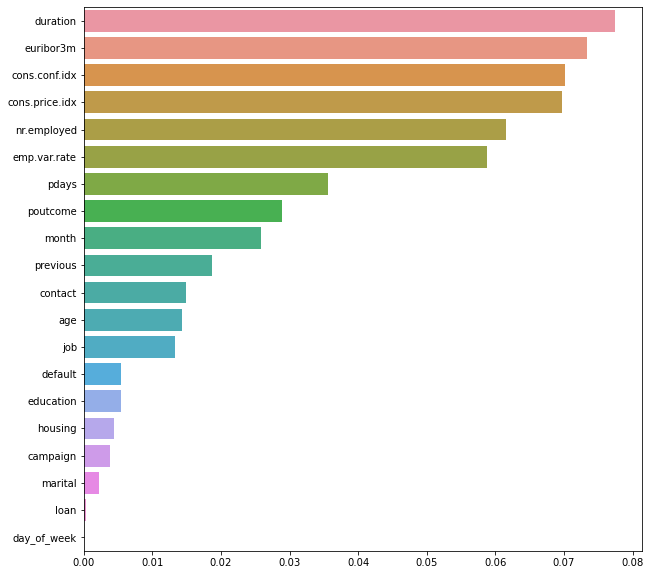

In [15]:
mi_scores = pd.Series(fs.scores_, index=X.columns).sort_values(ascending=False)
plt.figure(figsize=(10,10))
sns.barplot(x=mi_scores.values, y=mi_scores.index)
plt.show()

Como se indicaba en la descripción de las features, la variable ```duration``` está muy relacionada con el target, pero sin embargo no está disponible previo a la predicción. Por lo tanto, la saco del set de features

In [16]:
def drop_duration(X):
    return X.drop('duration', axis=1)

X = drop_duration(X)

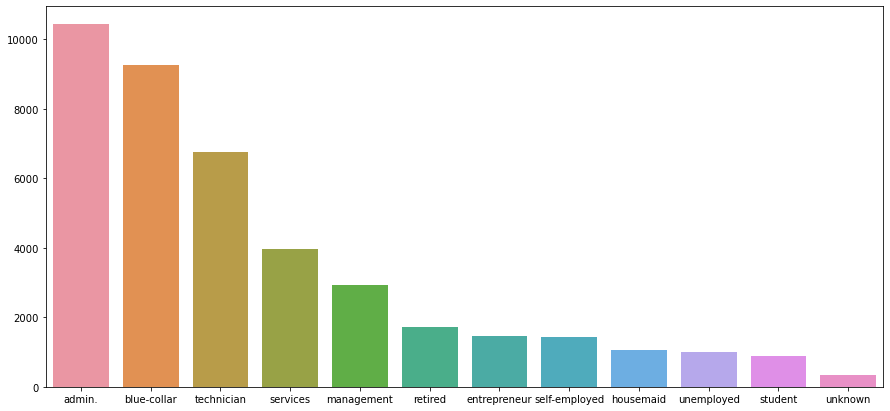

In [17]:
jobs = cat_features.job.value_counts()
plt.figure(figsize=(15,7))
sns.barplot(x=jobs.index, y=jobs.values)
plt.show()

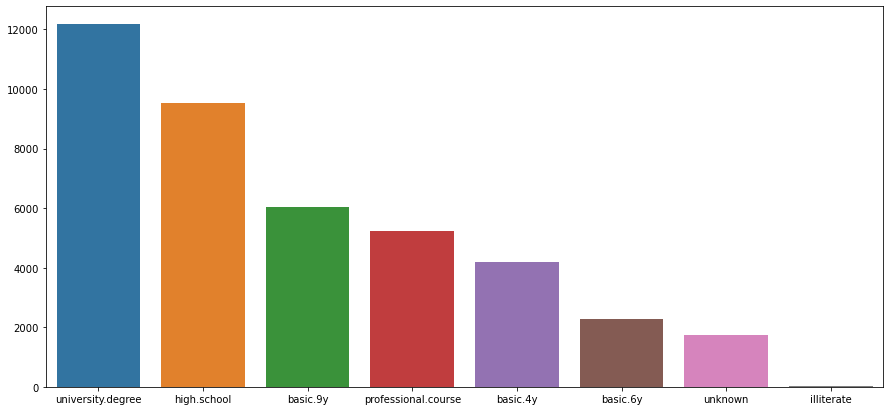

In [18]:
education = cat_features.education.value_counts()
plt.figure(figsize=(15,7))
sns.barplot(x=education.index, y=education.values)
plt.show()

### Variables numéricas

In [19]:
X = df.copy()
y = X.pop('y')

In [20]:
X.select_dtypes(['int64', 'float64'])

age  duration  campaign  pdays  previous  emp.var.rate  cons.price.idx  \
0       56       261         1    999         0           1.1          93.994   
1       57       149         1    999         0           1.1          93.994   
2       37       226         1    999         0           1.1          93.994   
3       40       151         1    999         0           1.1          93.994   
4       56       307         1    999         0           1.1          93.994   
...    ...       ...       ...    ...       ...           ...             ...   
41183   73       334         1    999         0          -1.1          94.767   
41184   46       383         1    999         0          -1.1          94.767   
41185   56       189         2    999         0          -1.1          94.767   
41186   44       442         1    999         0          -1.1          94.767   
41187   74       239         3    999         1          -1.1          94.767   

       cons.conf.idx  euribor3m  nr.employed  
0              -36.4      4.857       5191.0  
1              -36.4      4.857       5191.0  
2              -36.4      4.857       5191.0  
3              -36.4      4.857       5191.0  
4              -36.4      4.857       5191.0  
...              ...        ...          ...  
41183          -50.8      1.028       4963.6  
41184          -50.8      1.028       4963.6  
41185          -50.8      1.028       4963.6  
41186          -50.8      1.028       4963.6  
41187          -50.8      1.028       4963.6  

[41188 rows x 10 columns]

In [21]:
# defino el dataframe de la clase positiva
# observaré patrones dentro de las personas que se suscriben al servicio
credits = df[df.y=='yes']
X_pos_class = X.iloc[credits.index]
X_pos_class.shape

(4640, 20)

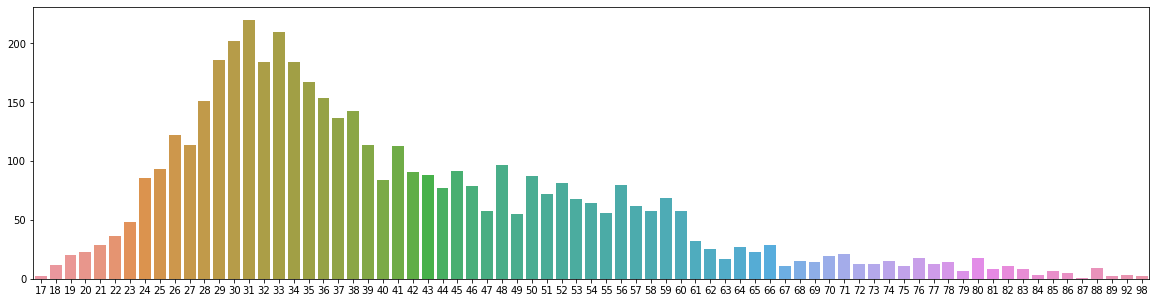

In [22]:
ages = credits.age.value_counts().sort_index()
plt.figure(figsize=(20,5))
sns.barplot(x=ages.index, y=ages.values)
plt.show()

In [23]:
def discretize_age(X):
    X['age_discrete'] = pd.cut(X.age, 7)
    X['age_discrete'] = LabelEncoder().fit_transform(X['age_discrete'])
    return X

In [24]:
credits.pdays.value_counts()[:3]

999    3673
3       298
6       289
Name: pdays, dtype: int64

In [25]:
def add_was_prev_contacted(X):
    X['was_prev_contacted'] = X.pdays.apply(lambda x: 0 if x == 999 else 1)
    return X

# Feature engineering
Reúno todas las funciones de feature engineering

In [26]:
def engineer_features(X):
    X = discretize_age(X)
#     X = add_was_prev_contacted(X)
    return X

# Modelado

In [27]:
def data_transformation(X, y):
    X, y = encode_data(X, y)
    X = engineer_features(X)
    return X, y

In [28]:
X = df.copy()
y = X.pop('y')
X, y = data_transformation(X, y)

X = X.drop(['day_of_week'], axis=1)

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=0)

### Resampling

Genero datos sintéticos de la clase minoritaria para balancear el dataset.

In [30]:
resample_pipe = imbalanced_pipeline([
    ('under', RandomUnderSampler(sampling_strategy=.3, random_state=42)),
    ('over', SMOTE(sampling_strategy=.9, random_state=42))
])
X_res, y_res = resample_pipe.fit_resample(X_train, y_train)
X_res = pd.DataFrame(data=X_res, columns=X_train.columns)
y_res = pd.Series(data=y_res)

In [31]:
print(X_res.shape)
print(y_res.shape)

(20596, 20)
(20596,)


In [32]:
pd.Series(y_res).value_counts()

0    10840
1     9756
dtype: int64

In [33]:
classifiers = {
    'LogisticRegression': LogisticRegression(random_state=42),
    'KNN': KNeighborsClassifier(),
    'RandomForest': RandomForestClassifier(random_state=42),
    'XGBClassifier': XGBClassifier(random_state=42),
    'CatBoostClassifier': CatBoostClassifier(random_state=42, verbose=False, iterations=100)
}

In [34]:
trained_classifiers = {}

for classifier_name, classifier in classifiers.items():
    t0 = time.time()
    classifier.fit(X_res, y_res)
    t1 = time.time()
    time_elapsed = round(t1 - t0, 2)

    trained_classifiers.update({classifier_name: classifier})
    print(f'Tiempo de train para {classifier_name}: {time_elapsed} segundos')

Tiempo de train para LogisticRegression: 0.45 segundos
Tiempo de train para KNN: 0.31 segundos
Tiempo de train para RandomForest: 0.54 segundos
[15:47:14] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Tiempo de train para XGBClassifier: 2.72 segundos
Tiempo de train para CatBoostClassifier: 3.1 segundos


## Evaluación de los modelos

In [35]:
metrics = pd.DataFrame(columns=['Model', 'Accuracy', 'Recall', 'AUC', 'AP'])

for classifier_name, classifier in trained_classifiers.items():
    y_preds = classifier.predict(X_test)
    classifier_metrics = pd.Series([
        classifier_name,
        accuracy_score(y_test, y_preds),
        recall_score(y_test, y_preds),
        roc_auc_score(y_test, y_preds),
        average_precision_score(y_test, y_preds)
    ], index=metrics.columns)
    metrics = metrics.append(classifier_metrics, ignore_index=True)
    
metrics

Model  Accuracy    Recall       AUC        AP
0  LogisticRegression  0.866796  0.855187  0.861726  0.401945
1                 KNN  0.846403  0.863833  0.854015  0.371463
2        RandomForest  0.898843  0.711095  0.816848  0.414723
3       XGBClassifier  0.904184  0.777378  0.848804  0.454274
4  CatBoostClassifier  0.906288  0.798991  0.859428  0.468293

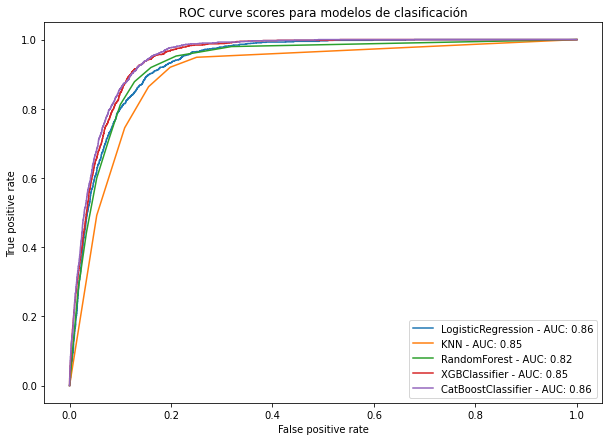

In [36]:
plt.figure(figsize=(10,7))
for classifier_name, classifier in trained_classifiers.items():
    y_preds = classifier.predict(X_test)
    preds_proba = classifier.predict_proba(X_test)
    pos_preds_proba = preds_proba[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, pos_preds_proba)
    auc_score = roc_auc_score(y_test, y_preds)
    
    plt.plot(fpr, tpr, label=f'{classifier_name} - AUC: {round(auc_score, 2)}')

plt.title('ROC curve scores para modelos de clasificación')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend()
plt.show()

Los scores en la curva ROC no son malos. Sorprende que Regresión logística sea el modelo con mejor área debajo de la curva. Sin embargo, como mencioné al principio, el tipo de problema que plantea el dataset requiere que detectemos falsos negativos en las predicciones de los modelos. Para eso, observo la curva de precision-recall.

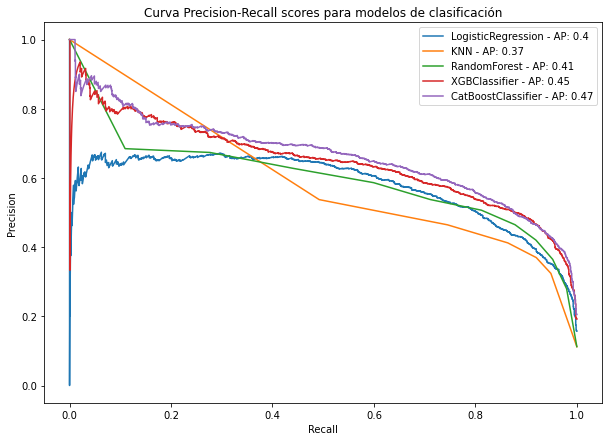

In [37]:
plt.figure(figsize=(10,7))
for classifier_name, classifier in trained_classifiers.items():
    y_preds = classifier.predict(X_test)
    preds_proba = classifier.predict_proba(X_test)
    pos_preds_proba = preds_proba[:, 1]
    precision, recall, thresholds = precision_recall_curve(y_test, pos_preds_proba)
    avg_precision = average_precision_score(y_test, y_preds)
    
    plt.plot(recall, precision, label=f'{classifier_name} - AP: {round(avg_precision, 2)}')

plt.title('Curva Precision-Recall scores para modelos de clasificación')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

Regresión logística sigue estando entre los mejores modelos, pero en este en este caso CatBoost tiene una mejor perfomance. Observo con mayor detalle estos dos modelos.

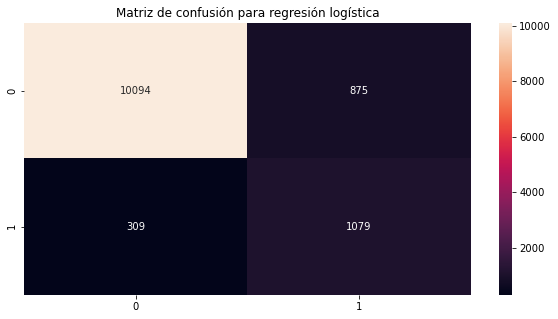

In [38]:
logit = trained_classifiers['XGBClassifier']
logit_preds = logit.predict(X_test)

plt.figure(figsize=(10,5))
sns.heatmap(confusion_matrix(y_test, logit_preds), annot=True, fmt='g')
plt.title('Matriz de confusión para regresión logística')
plt.show()

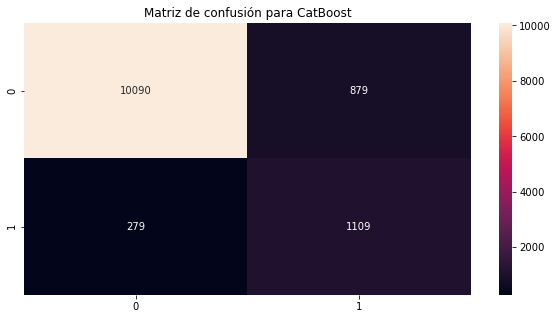

In [39]:
catboost = trained_classifiers['CatBoostClassifier']
catboost_preds = catboost.predict(X_test)

plt.figure(figsize=(10,5))
sns.heatmap(confusion_matrix(y_test, catboost_preds), annot=True, fmt='g')
plt.title('Matriz de confusión para CatBoost')
plt.show()

# Conclusión

Los dos modelos con mejor performance en general fueron Regresión logística y CatBoost. 
- CatBoost tiene un accuracy alto para predecir la clase mayoritaria, pero no logra predecir efectivamente la clase minoritaria. Esto quiere decir que va a predecir bien a clientes que no se suscribirán al servicio, pero no tan bien a los que sí se suscribirán.
- El caso de Regresión logística es inverso: este modelo es muy efectivo para detectar clientes que se van a suscribir al servicio, pero no tanto para detectar a los que no. Además, tiene una presencia importante de falsos positivos, lo que quiere decir que considerará como potenciales suscriptoras a personas que en realidad no están interesadas.

Dada la naturaleza del problema, tener una mayor cantidad de falsos negativos no parece ser grave. Diferente sería si se tratara de un problema de detección de fraudes o de células cancerígenas, en donde es muy importante poder anticipar casos positivos. Además, dado que lo que se intenta predecir es si un cliente se suscribirá a un servicio, saber cuándo no van a suscribirse es importante para no perder demasiado tiempo intentando contactar a esa persona. Por lo tanto, considero que el mejor modelo es CatBoost

In [40]:
param_grid = {
    'max_depth': np.arange(2,11, 2),
    'n_estimators': np.arange(10,5001,100),
    'learning_rate': [.001, .05, .1],
    'min_child_weight': np.arange(1,11, 2),
    'colsample_bytree': np.append(np.arange(.2,1,.3),1),
    'subsample': np.append(np.arange(.2,1,.3),1),
    'reg_alpha': np.arange(0,11,2),
    'reg_lambda': np.arange(0,11,2)
}

model = XGBClassifier(random_state=42)
search = GridSearchCV(model, param_grid, n_jobs=-1)

t0 = time.time()
# search.fit(X_res, y_res)
t1 = time.time()

time_elapsed = t1 - t0